### Урок 3. Домашняя работа

**Задание простого уровня** Загрузите данные из файла `non_linear.csv` и сгенерируйте данные до степени *degree = 8* включительно. Обучите модель `sklearn.linear_model.Lasso` и модель `sklearn.linear_model.Ridge` на полученных данных, используйте коэффициент регуляризации $\alpha=0.8$ для обеих моделей. Постройте два столбчатых графика, на которых отобразите величину коэффициентов для Ridge регрессии и Lasso регрессии в виде столбиков.


Пример графиков для 3-й степени (просто для примера, у вас может по-другому выглядеть). Какой можно сделать в вывод по величине коэффициентов?:

![coeff_example](https://pp.userapi.com/c850136/v850136613/19282c/OfwruuxOkPw.jpg)

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.1854084292436, tolerance: 0.0068452843448398625
  model = cd_fast.enet_coordinate_descent(


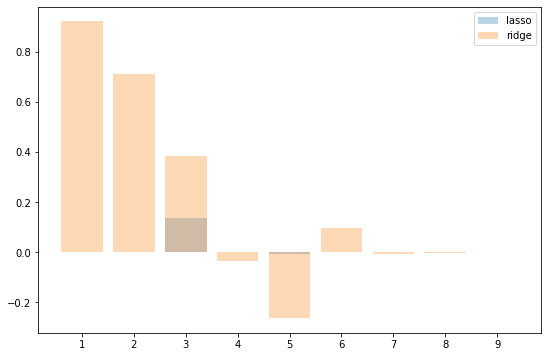

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge

data = pd.read_csv("non_linear.csv")
X_train = PolynomialFeatures(degree=8).fit_transform(np.array(data.x_train).reshape(-1, 1))
y_train = np.array(data.y_train).reshape(-1, 1)

alpha = 0.8 
lasso = Lasso(fit_intercept=False, alpha=alpha).fit(X_train, y_train)
ridge = Ridge(fit_intercept=False, alpha=alpha).fit(X_train, y_train)

lasso_w = lasso.coef_
ridge_w = ridge.coef_[0]  # Ridge.coef_ returns [[]] while lasso.coef_ returns [] 

plt.figure(figsize=(9, 6))
x = np.arange(1, len(lasso_w) + 1)
plt.bar(x, lasso_w, label="lasso", alpha=.3)
plt.bar(x, ridge_w, label="ridge", alpha=.3)
plt.xticks(x)
plt.legend();


In [42]:
np.arange(1, len(lasso_w))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Коэфициенты, полученные при обучении Ridge значительно меньше, полученных обученем Lasso.

### Урок 8. Домашняя работа

**Задание среднего уровня** Примените градиентный спуск к задаче прогнозирования цен на недвижимость в Бостоне. Какого качества на валидации удалось достичь по r2-score? Сколько итераций  понадобилось?

In [49]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [51]:
from typing import Any, Tuple
from scipy.spatial import distance as dst
import numpy as np


def get_weights(n_cols: int) -> np.ndarray:
  return np.ones((n_cols, 1))


def grad_step(X: np.ndarray, 
              y: np.ndarray, 
              w: np.ndarray, 
              *, step=0.0001, 
              alpha=1.0) -> np.ndarray:

  # return w - 2 * step * (X.T.dot(X.dot(w) - y) / X.shape[0] + alpha * w)
  return w - 2 * step * (X.T.dot(X.dot(w) - y) + alpha * w)


def add_intercept(X: np.ndarray) -> np.ndarray:
    return np.hstack([X, np.ones((X.shape[0], 1))])


def grad_descent(X: np.ndarray, 
                 y: np.ndarray, 
                 *, max_iter=1000, 
                 alpha=1.0, 
                 eps=0.001) -> Tuple[np.ndarray, int, bool]:
  X = add_intercept(X)
  _grad_step = lambda w: grad_step(X, y, w, alpha=alpha)

  w1 = get_weights(X.shape[1])
  w2 = _grad_step(w1)

  iter = 0
  while dst.euclidean(w1, w2) > eps and iter < max_iter:

    w1, w2 = w2, _grad_step(w2)
    iter += 1

  return w2, iter, iter != max_iter


def predict(X: np.ndarray, w: np.ndarray) -> np.ndarray:
  return add_intercept(X).dot(w)


## =========== Model evaluation ===========
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


def eval_and_report(w: np.ndarray, 
                    rival: Any, 
                    header: str, 
                    iters: int, 
                    early_exit: bool) -> None:
  print(f"{header.upper()}: iterations={iters}  early_exit={early_exit}")

  fmt = ":0<06.04"

  y_pred = predict(X_train_scaled, w)
  print(f"my train error:    sq_err={{{fmt}}}  r2={{{fmt}}}".format(
      mean_squared_error(y_train, y_pred),
      r2_score(y_train, y_pred)
  ))

  y_pred = rival.predict(X_train_scaled)
  print(f"their train error: sq_err={{{fmt}}}  r2={{{fmt}}}".format(
      mean_squared_error(y_train, y_pred),
      r2_score(y_train, y_pred)
  ))

  y_pred = predict(X_test_scaled, w)
  print(f"my test error:     sq_err={{{fmt}}}  r2={{{fmt}}}".format(
      mean_squared_error(y_test, y_pred),
      r2_score(y_test, y_pred)
  ))

  y_pred = rival.predict(X_test_scaled)
  print(f"their test error:  sq_err={{{fmt}}}  r2={{{fmt}}}".format(
      mean_squared_error(y_test, y_pred),
      r2_score(y_test, y_pred)
  ))


### =========== No regularization ===========
w, iters, early_exit = grad_descent(X_train_scaled, y_train.reshape(-1, 1), max_iter=1000, eps=0.001, alpha=0)
rival = LinearRegression().fit(X_train_scaled, y_train)

eval_and_report(w, rival, "No regularization", iters, early_exit)
print()

### =========== Ridge ===========
w, iters, early_exit = grad_descent(X_train_scaled, y_train.reshape(-1, 1), max_iter=1000, eps=0.001, alpha=1.0)
rival = Ridge(solver="lsqr").fit(X_train_scaled, y_train)

eval_and_report(w, rival, "Ridge", iters, early_exit)
print()

### =========== Ridge Closed Form ===========
x = add_intercept(X_train_scaled)
alpha = 1.0
w = np.linalg.inv(x.T @ x + alpha * np.ones((x.shape[1], x.shape[1]))) @ x.T @ y_train
rival = Ridge(solver="cholesky").fit(X_train_scaled, y_train)

eval_and_report(w, rival, "Ridge Closed Form", 1, False)


NO REGULARIZATION: iterations=534  early_exit=True
my train error:    sq_err=19.230  r2=0.7501
their train error: sq_err=19.230  r2=0.7501
my test error:     sq_err=34.420  r2=0.6709
their test error:  sq_err=34.410  r2=0.6709

RIDGE: iterations=515  early_exit=True
my train error:    sq_err=19.240  r2=0.7500
their train error: sq_err=19.230  r2=0.7501
my test error:     sq_err=34.480  r2=0.6703
their test error:  sq_err=34.330  r2=0.6717

RIDGE CLOSED FORM: iterations=1  early_exit=False
my train error:    sq_err=19.270  r2=0.7496
their train error: sq_err=19.230  r2=0.7501
my test error:     sq_err=34.500  r2=0.6701
their test error:  sq_err=34.390  r2=0.6711


### Урок 12. Домашняя работа

**Задача высокого уровня** В реализацию функции `gradient` добавьте параметр $\lambda$, чтобы получить регуляризованный градиентный спуск


> Indented block


Формула поменяется следующим образом:
$$
\left\{
\begin{array}{cc}
\frac{\partial L}{\partial w_0} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} (1\cdot \left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) + \lambda\cdot 2\cdot w_0)&\\
\frac{\partial L}{\partial w_k} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} (x_k^i \cdot\left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) + \lambda\cdot 2\cdot w_k)& k\neq 0 \\
\end{array}
\right.
$$

См. Реализацию выше. 